In [1]:
# import packages
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
import matplotlib.patches as mpatches
from scipy import stats

In [2]:
# Settings
ID = "0704"
figure_path = "figs" + os.sep + ID + os.sep

if not os.path.exists(figure_path):
    os.makedirs(figure_path)
figure_path = figure_path + "expDetermineProb_"


# Figure settings
sns.set_style("darkgrid")

INIT_COL = sns.color_palette('colorblind')[0]
RESP_COL = sns.color_palette('colorblind')[1]

meanpointprops = dict(marker='D', markeredgecolor='black', markerfacecolor=sns.color_palette('colorblind')[2], markersize=8)
whiskerprops = dict(alpha=0.4, linestyle="dashed")
capprops = dict(alpha=0.4)
medianprops = dict(lw=2, color="black")
boxprops = dict(facecolor=INIT_COL, color="black", alpha=0.5)

TICK_SIZE = 20
VALUE_SIZE = 14
LABEL_SIZE = 26
FIG_SIZE = (12,7)

In [3]:
directory = "../results/results_" + ID + "_determine_prob"
idx = 0
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if not filename.endswith(".csv"):
        continue
    newdata = pd.read_csv(f, index_col = None)
    if (idx == 0):
        data = newdata
    else:
        data = pd.concat([data, newdata], ignore_index = True)
    idx += 1
    
print("Number of observations: " + str(len(data.index)))
print("Number of observations per group: " + str(len(data.index) / 99))

Number of observations: 99000
Number of observations per group: 1000.0


In [4]:
data[(data["init_gain"] < 0) | (data["resp_gain"] < 0)][["init_tom", "resp_tom", "init_gain", "resp_gain"]]

,init_tom,resp_tom,init_gain,resp_gain
4058,2,0,-100,150
34397,0,2,50,-50
40842,0,2,50,-50
43942,2,0,-100,50
73112,0,2,50,-100


In [5]:
keep_columns = ["init_zeroToMProb", "resp_zeroToMProb", "init_tom", "resp_tom", "init_gain", "resp_gain",
                "resp_highestValueParetoOutcome", "init_highestValueParetoOutcome", "init_canLie", "resp_canLie"]

def apply_data_transformation(data):
    # Ensures that the data is in the format for plotting
    df = copy.deepcopy(data[keep_columns])
    df["zeroToMProb"] = df.apply(lambda x: x["init_zeroToMProb"] if (x["init_tom"] == 0) else x["resp_zeroToMProb"], axis=1)
    df["name"] = df.apply(lambda x: "init_resp" if ((x["init_tom"] == 0) and (x["resp_tom"] == 0)) else ("init" if x["init_tom"] == 0 else "resp"), axis=1)
    
    sub_df = df.loc[(df["name"] == "init_resp")].copy()
    sub_df.loc[:, "name"] = "init"
    df = pd.concat([sub_df, df]).reset_index(drop=True)
    
    sub_df = df.loc[(df["name"] == "init_resp")].copy()
    sub_df.loc[:, "name"] = "resp"
    df = pd.concat([sub_df, df]).reset_index(drop=True)

    df = df.loc[df["name"] != "init_resp"]
    df["gain"] = df.apply(lambda x: x["init_gain"] if x["name"] == "init" else x["resp_gain"], axis=1)
    
    return df


In [6]:
df_transformed = apply_data_transformation(data)

In [7]:
print(f'number of observations where score gain is below 0: {len(df_transformed[df_transformed["gain"] < 0])}')

number of observations where score gain is below 0: 0


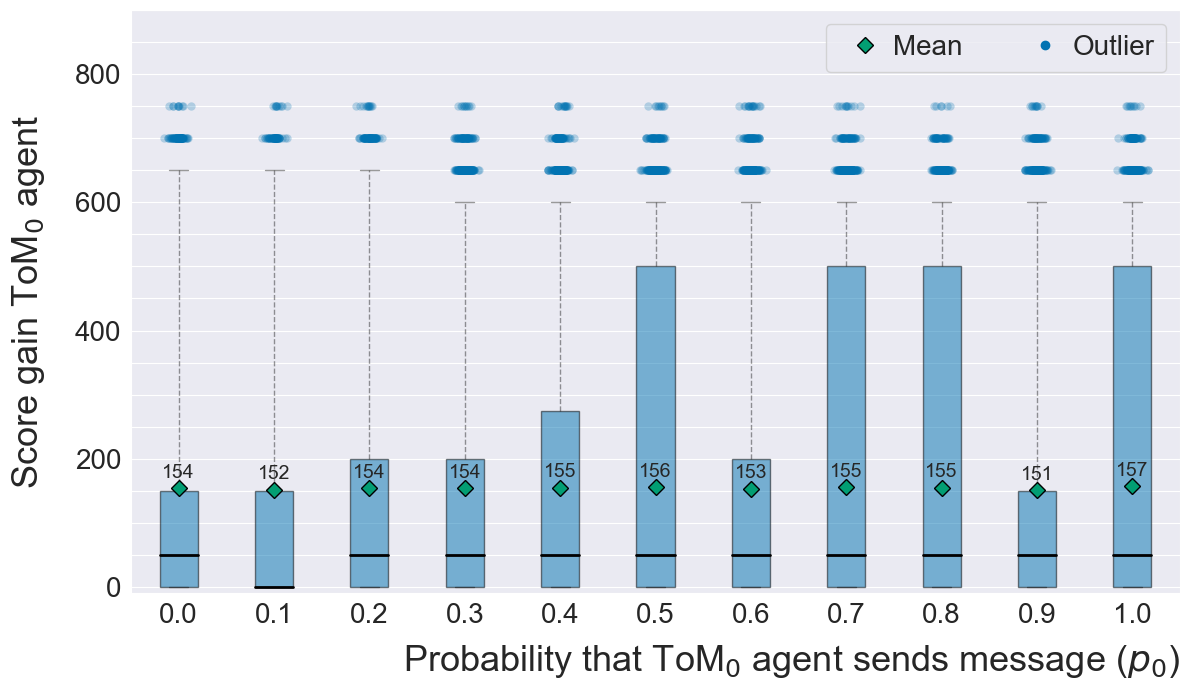

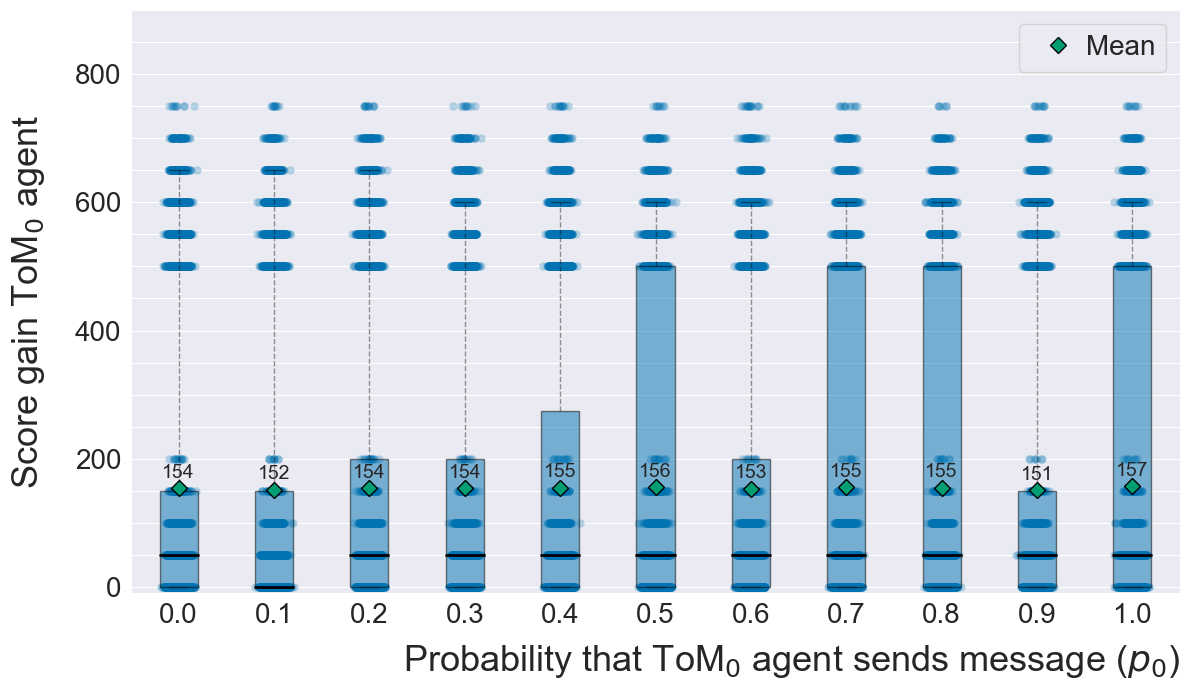

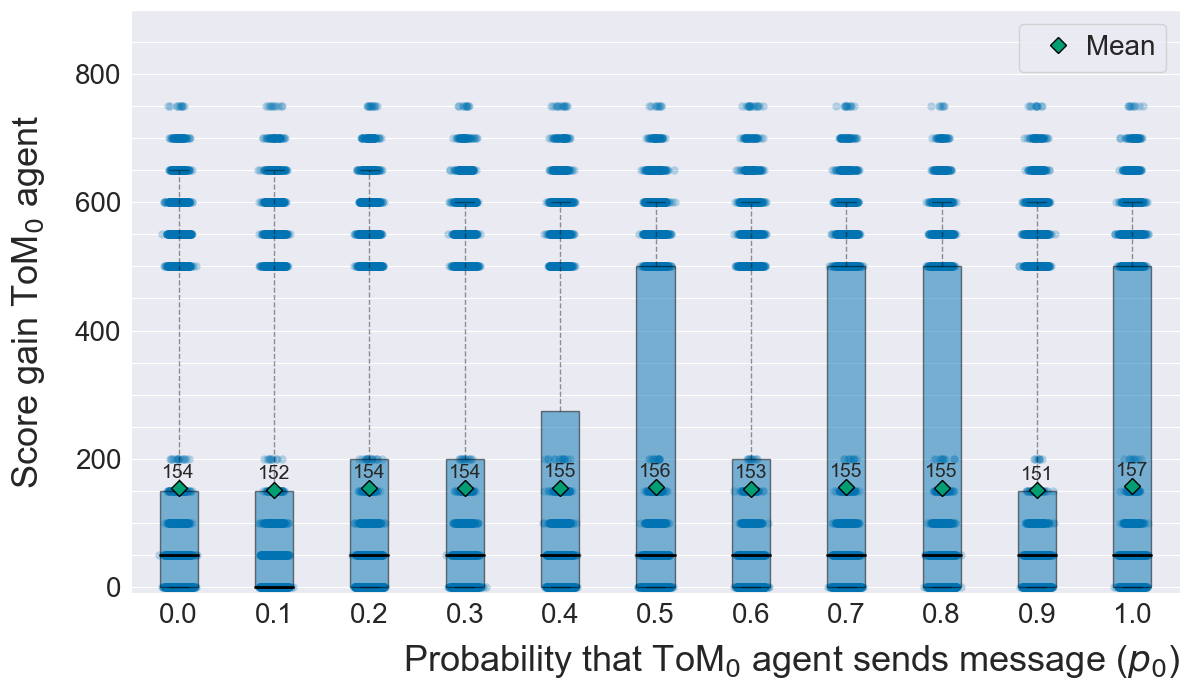

In [8]:
BIN_WIDTH = 0.4

def make_box_plot(data, pos, ax, draw_points):
    bp = ax.boxplot(data, patch_artist=True, notch=False, vert=1, showfliers=True, whis=[2.5, 97.5],
                    positions=pos, widths=BIN_WIDTH, showmeans=True, meanprops=meanpointprops,
                    whiskerprops=whiskerprops, medianprops=medianprops, capprops=capprops,
                    boxprops=boxprops)
    
    plt.setp(bp['fliers'][0], color='black', alpha=0)
    
    if draw_points:
        x = np.random.normal(pos[0], 0.05, size=len(data))
        y = data
        ax.scatter(x, y, color=INIT_COL, alpha=0.25, linewidth=0)
    else:
        top_points = bp["fliers"][0].get_data()
        x = np.random.normal(top_points[0], 0.05, size=len(top_points[0]))
        y = top_points[1]
        ax.scatter(x, y, color=INIT_COL, alpha=0.25, linewidth=0)
    
    
def make_plot(data, draw_points):
    fig, ax = plt.subplots(figsize = FIG_SIZE)
    max_mean = 0

    for i in range(0, 11, 1):
        plot_data = list(data[data["zeroToMProb"] == i/10]["gain"])
        make_box_plot(plot_data, [i], ax, draw_points)
        
        new_val = np.mean(plot_data)
        ax.text(i, new_val+10, round(new_val), size=VALUE_SIZE, ha="center", va='bottom')
        max_mean = np.max([new_val, max_mean])
        
    ax.tick_params(axis='both', labelsize=TICK_SIZE)
    ax.set_xticklabels([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_ylim(top=900, bottom=-10)
    if draw_points:
        ax.legend([plt.Line2D([0], [0], color=meanpointprops["markerfacecolor"], marker=meanpointprops["marker"], 
                                markeredgecolor=meanpointprops["markeredgecolor"], markersize=meanpointprops["markersize"], linewidth=0)],
                ["Mean"], fontsize=TICK_SIZE, fancybox=True, loc="upper right", handletextpad=0)
    else:
        ax.legend((plt.Line2D([0], [0], color=meanpointprops["markerfacecolor"], marker=meanpointprops["marker"], 
                                markeredgecolor=meanpointprops["markeredgecolor"], markersize=meanpointprops["markersize"], linewidth=0),
                plt.Line2D([0],[0], color=INIT_COL, marker="o", linewidth=0, alpha=1)),
                ("Mean", "Outlier"), fontsize=TICK_SIZE, ncol=2, fancybox=True, loc="upper right", handletextpad=0)
    
    ax.xaxis.grid(False, which ="both")
    ax.yaxis.grid(True, which="both")

    ax.set_ylabel(r"Score gain ToM$_0$ agent", fontsize=LABEL_SIZE, labelpad=20)
    ax.set_xlabel(r"Probability that ToM$_0$ agent sends message ($p_0$)", fontsize=LABEL_SIZE, loc="right", labelpad=10)
    fig.tight_layout()
    plt.minorticks_on()

make_plot(df_transformed, False)
plt.savefig(figure_path + "boxplot.pdf")

make_plot(df_transformed, True)
plt.savefig(figure_path + "boxplot_with_points.png")

make_plot(df_transformed, True)
plt.savefig(figure_path + "boxplot_with_points.pdf")

In [9]:
data_list = [list(df_transformed[df_transformed["zeroToMProb"] == i/10]["gain"]) for i in range(0, 11,1)]
print(stats.kruskal(*data_list))
print(stats.f_oneway(*data_list))

KruskalResult(statistic=8.99137731444199, pvalue=0.5329220976236391)
F_onewayResult(statistic=0.514630394708275, pvalue=0.8811881527183493)


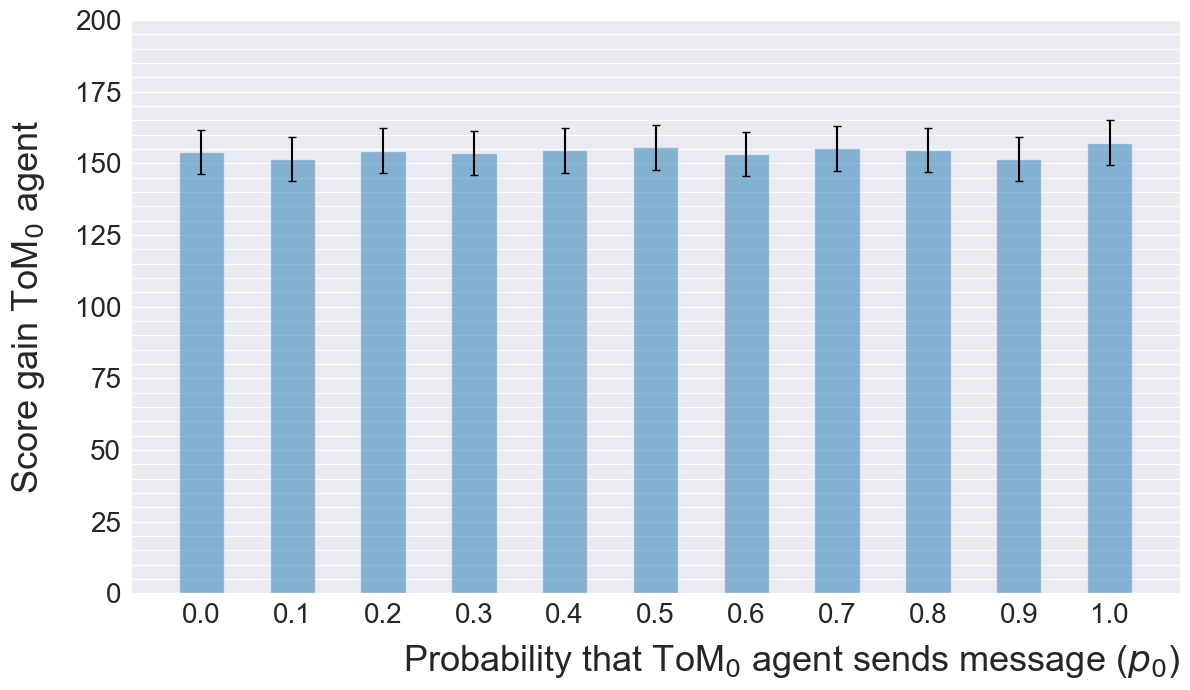

In [10]:
BIN_WIDTH = 0.05


def make_bar_plot(data, ax):
    means = [i for i, _ in data.values()]
    errors = [i for _, i in data.values()]
    ax.bar(data.keys(), means, width=BIN_WIDTH, alpha=0.5, yerr=errors, capsize=3)
    
def make_plot(data):
    fig, ax = plt.subplots(figsize = FIG_SIZE)
    max_mean = 0
    plot_dict = {}
    confidence = 1 - (0.05 / 55) / 2  # even without adjustment, the confidence intervals overlap
    
    for i in range(0, 11, 1):
        plot_data = list(data[data["zeroToMProb"] == i/10]["gain"])
        t_stat = stats.t.ppf(confidence, len(plot_data) - 1)
        plot_dict[i/10] = (np.mean(plot_data), t_stat * np.std(plot_data) / math.sqrt(len(plot_data)))
        max_mean = max(max_mean, np.mean(plot_data))
        
    make_bar_plot(plot_dict, ax)
    
    ax.tick_params(axis='both', labelsize=TICK_SIZE)
    ax.set_ylim(top=200, bottom=0)
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    
    ax.xaxis.grid(False, which ="both")
    ax.yaxis.grid(True, which="both")

    ax.set_ylabel(r"Score gain ToM$_0$ agent", fontsize=LABEL_SIZE, labelpad=20)
    ax.set_xlabel(r"Probability that ToM$_0$ agent sends message ($p_0$)", fontsize=LABEL_SIZE, loc="right", labelpad=10)
    fig.tight_layout()
    plt.minorticks_on()
    
make_plot(df_transformed)
plt.savefig(figure_path + "barplot_with_CI.pdf")

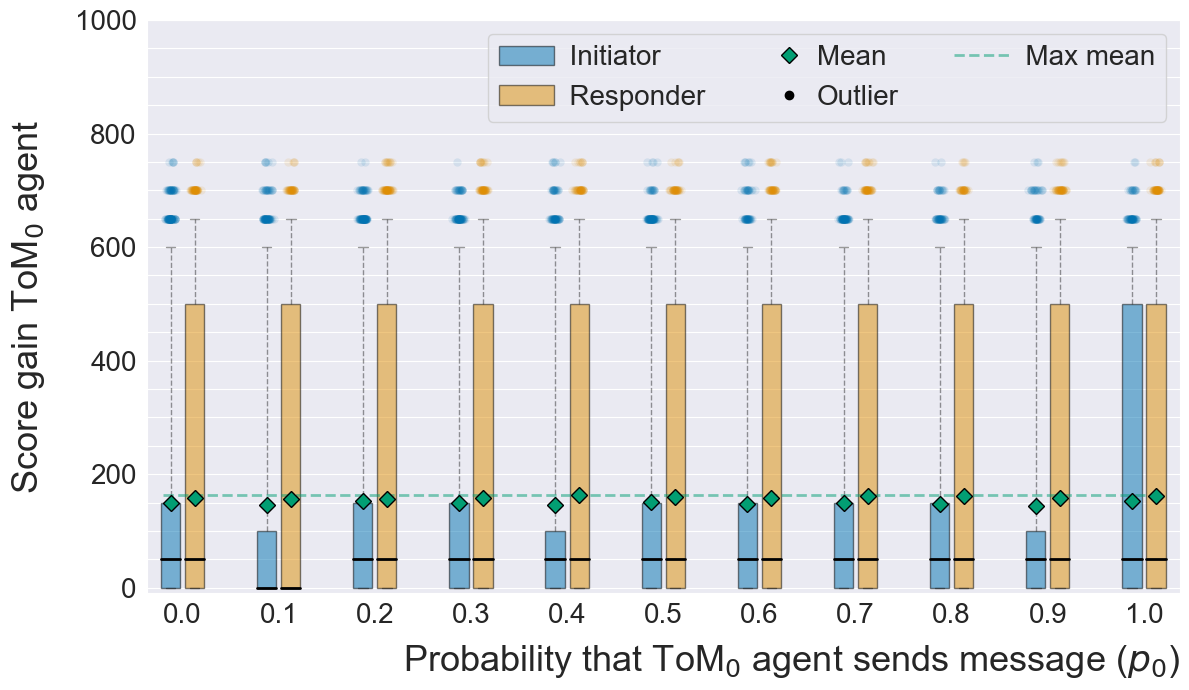

In [11]:
BIN_WIDTH = 0.4

def make_box_plot_multiple(data, pos, ax):
    bp = ax.boxplot(data, patch_artist=True, notch=False, vert=1, showfliers=True, whis=[2.5, 97.5],
                    positions=pos, widths=BIN_WIDTH, showmeans=True, meanprops=meanpointprops,
                    whiskerprops=whiskerprops, medianprops=medianprops, capprops=capprops,
                    boxprops=boxprops)

    bp['boxes'][0].set(facecolor=INIT_COL)
    bp['boxes'][1].set(facecolor=RESP_COL)
    
    plt.setp(bp['fliers'][0], color='black', alpha=0)
    plt.setp(bp['fliers'][1], color='black', alpha=0)
    
    fill_colors = [INIT_COL, RESP_COL]
    for i in [0,1]:
        top_points = bp["fliers"][i].get_data()
        x = np.random.normal(top_points[0], 0.05, size=len(top_points[0]))
        y = top_points[1]
        ax.scatter(x, y, color=fill_colors[i], alpha=0.1, linewidth=0)

def make_plot_differentiate(data):
    fig, ax = plt.subplots(figsize = FIG_SIZE)
    max_mean_init = 0
    max_mean_resp = 0

    for i in range(0, 21, 2):
        plot_data = [list(data[(data["zeroToMProb"] == i/20) & (data["name"] == "init")]["gain"]),
                    list(data[(data["zeroToMProb"] == i/20) & (data["name"] == "resp")]["gain"])]
        make_box_plot_multiple(plot_data, [i-0.25, i+0.25], ax)
        
        new_val_init = np.mean(plot_data[0])
        new_val_resp = np.mean(plot_data[1])
        max_mean_init = np.max([new_val_init, max_mean_init])
        max_mean_resp = np.max([new_val_resp, max_mean_resp])
        
    # Add horizontal line
    ax.hlines(y=np.max([max_mean_init, max_mean_resp]), xmin=-BIN_WIDTH, xmax=20+BIN_WIDTH, linestyles='dashed', label='smt', lw=2, colors=meanpointprops["markerfacecolor"],
              alpha=0.5)
        
    handles, _ = ax.get_legend_handles_labels()
    # ax.yaxis.set_tick_params(pad=1.6*max(T.label1.get_window_extent().width for T in ax.yaxis.majorTicks))
    ax.tick_params(axis='both', labelsize=TICK_SIZE)
    ax.set_xticks(range(0, 21, 2))
    ax.set_xticklabels([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_ylim(top=1000, bottom=-10)
    ax.legend((mpatches.Patch(facecolor=INIT_COL, edgecolor='black', label="Initiator", alpha=boxprops["alpha"]),
            mpatches.Patch(facecolor=RESP_COL, edgecolor='black', label="Responder", alpha=boxprops["alpha"]),
            plt.Line2D([0], [0], color=meanpointprops["markerfacecolor"], marker=meanpointprops["marker"], 
                            markeredgecolor=meanpointprops["markeredgecolor"], markersize=meanpointprops["markersize"], linewidth=0),
            plt.Line2D([],[], color="black", marker="o", markeredgecolor="black", linewidth=0), 
            handles[0]),
                ("  Initiator", "  Responder", "Mean", "Outlier", "  Max mean"), fontsize=TICK_SIZE, ncol=3, fancybox=True, loc="upper right",
                handletextpad=0)
    ax.xaxis.grid(False, which ="both")
    ax.yaxis.grid(True, which="both")

    ax.set_ylabel(r"Score gain ToM$_0$ agent", fontsize=LABEL_SIZE, labelpad=20)
    ax.set_xlabel(r"Probability that ToM$_0$ agent sends message ($p_0$)", fontsize=LABEL_SIZE, loc="right", labelpad=10)
    fig.tight_layout()
    plt.minorticks_on()

make_plot_differentiate(df_transformed)
plt.savefig(figure_path + "boxplot_separate.pdf")

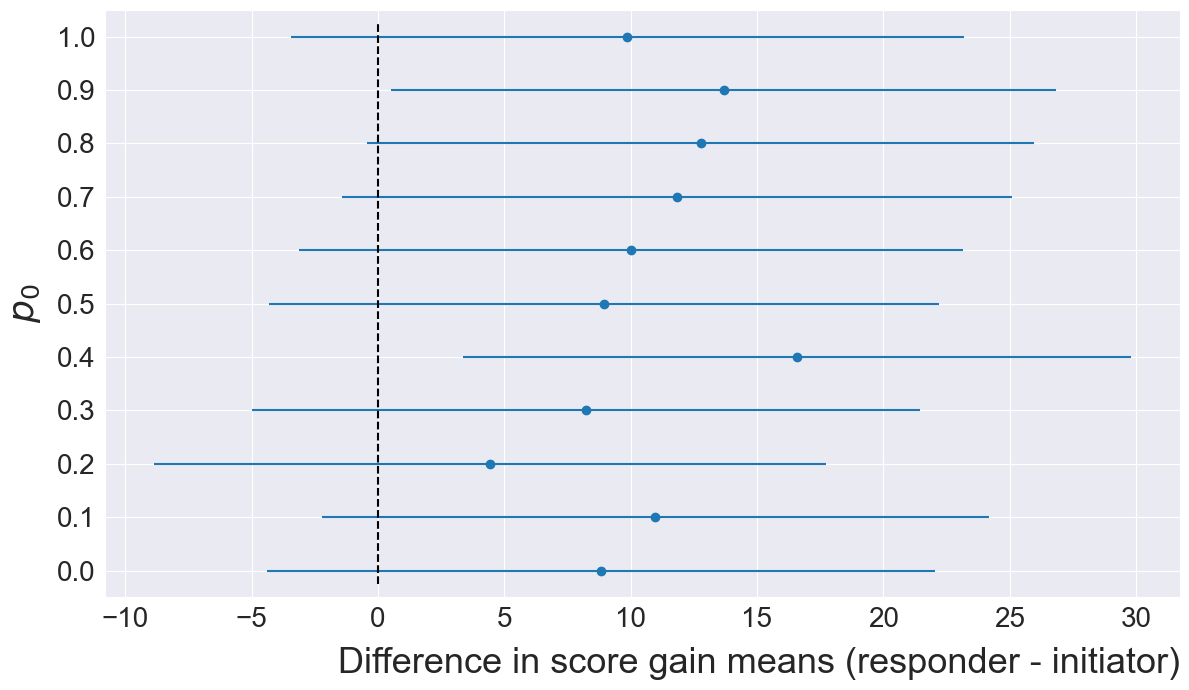

In [12]:
def make_difference_plot():
    # Calculate the means for each group and setting
    means = df_transformed.groupby(['name', 'zeroToMProb'])['gain'].mean().unstack()

    # Calculate the difference in means
    diff_means = means.iloc[1, :] - means.iloc[0, :]

    # Reset the index
    diff_means = diff_means.reset_index()
    diff_means.columns = ["zeroToMProb", "diff_gain"]

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize = FIG_SIZE)

    errors = []
    confidence = 1 - (0.05 / 11) / 2  # two-tailed
    # confidence = 0.95
    for _, row in diff_means.iterrows():
        stat_data_init = df_transformed[(df_transformed["zeroToMProb"] == row["zeroToMProb"]) & (df_transformed["name"] == "init")]
        var_init = (np.std(stat_data_init["gain"]))**2
        n_init = len(stat_data_init)
        stat_data_resp = df_transformed[(df_transformed["zeroToMProb"] == row["zeroToMProb"]) & (df_transformed["name"] == "resp")]
        var_resp = (np.std(stat_data_resp["gain"]))**2
        n_resp = len(stat_data_resp)
        df = ((var_init / n_init + var_resp / n_resp)**2) / (((var_init / n_init)**2) /  (n_init - 1) + ((var_resp / n_resp)**2) / (n_resp - 1))
        t_stat = stats.t.ppf(confidence, df)
        errors.append(t_stat * math.sqrt((var_init) / n_init + (var_resp) / n_resp))
        
    # plot the difference
    ax.errorbar(diff_means['diff_gain'], diff_means['zeroToMProb'], fmt="o", xerr=errors)
    ax.vlines(0, ymin = -0.025, ymax=1.025, linestyle='dashed', color="black")

    ax.tick_params(axis='both', labelsize=TICK_SIZE)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_yticklabels([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_ylim((-0.05, 1.05))

    # Set labels
    ax.set_xlabel("Difference in score gain means (responder - initiator)", fontsize=LABEL_SIZE, loc="right", labelpad=10)
    ax.set_ylabel(r"$p_0$", fontsize=LABEL_SIZE,  labelpad=10)
    fig.tight_layout()
    plt.minorticks_on()

make_difference_plot()
plt.savefig(figure_path + "difference_means.pdf")
